# Practical Machine Learning in Python with PyTorch
## MNIST Digit Classification Example

This notebook demonstrates the complete machine learning workflow using PyTorch and the MNIST dataset. We'll follow these steps:

1. Define the Problem
2. Assemble Dataset
3. Decide on Evaluation Protocol
4. Prepare Data
5. Develop Baseline Model
6. Build Better Model
7. Optimize Hyperparameters

In [1]:
# Setup - Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## Step 1: Define the Problem

Our task is to build a model that recognizes handwritten digits (0-9) from grayscale images. This is a:
- Multi-class classification problem
- Using the MNIST dataset
- Input: 28x28 pixel grayscale images
- Output: Digit classification (0-9)

## Step 2: Assemble Dataset

We'll use the MNIST dataset provided by torchvision:

In [ ]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load training data
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Download and load test data
test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Display some basic dataset information
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")
print(f"Number of classes: {len(train_dataset.classes)}")

Training set size: 60000
Test set size: 10000
Image shape: torch.Size([1, 28, 28])
Number of classes: 10


Let's visualize some examples from our dataset:

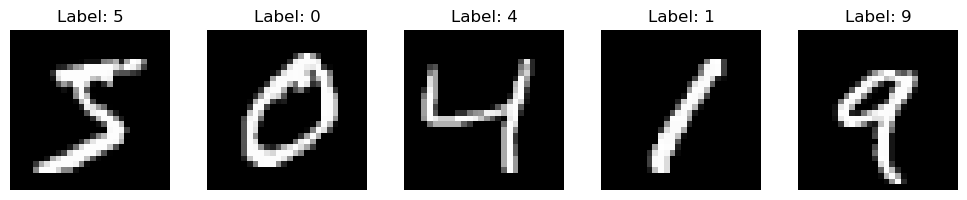

In [3]:
def show_images(dataset, num_images=5):
    # pick random images from the dataset
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        img, label = dataset[i]
        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_images(train_dataset)

## Step 3: Decide on Evaluation Protocol

We'll use:
- Accuracy as our primary metric
- Confusion matrix for detailed analysis
- 80% training, 20% validation split
- Compare with human performance (~98%)

In [4]:
# Create data loaders with the evaluation split
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    return accuracy, all_preds, all_labels

## Step 4: Prepare Data

Our data preparation steps:
1. Convert to tensors (done in transforms)
2. Normalize pixel values
3. Create data loaders (done above)
4. Move data to appropriate device

## Step 5: Develop Baseline Model

Let's start with a simple linear model as our baseline:

In [5]:
statistical_baseline = 1 / len(train_dataset.classes)

print(f'Statistical baseline: {statistical_baseline * 100:.2f}%')

Statistical baseline: 10.00%


## Step 6: Build Better Model

Now let's build a CNN that should perform better:

In [6]:
# Define the baseline model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.weights = nn.Parameter(torch.randn(28 * 28, 10))
        self.bias = nn.Parameter(torch.randn(10))

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        return torch.matmul(x, self.weights) + self.bias

baseline_model = Model().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(baseline_model.parameters(), lr=0.01)

# Train baseline model
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.3f}')

print("Training baseline model...")
train_model(baseline_model, train_loader, criterion, optimizer)

# Evaluate baseline
baseline_accuracy, baseline_preds, baseline_labels = evaluate_model(baseline_model, test_loader)
print(f'\nBaseline Model Accuracy: {baseline_accuracy:.2f}%')


Training baseline model...
Epoch 1, Loss: 12.588
Epoch 2, Loss: 4.310
Epoch 3, Loss: 3.269
Epoch 4, Loss: 2.791
Epoch 5, Loss: 2.498
Epoch 6, Loss: 2.295
Epoch 7, Loss: 2.142
Epoch 8, Loss: 2.023
Epoch 9, Loss: 1.921
Epoch 10, Loss: 1.837

Baseline Model Accuracy: 85.62%


## Step 7: Optimize Hyperparameters

Let's try different hyperparameters to improve our CNN:

In [7]:
optimised_model = Model().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(optimised_model.parameters(), lr=0.001)

# Train baseline model
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.3f}')

print("Training Optimised model...")
train_model(optimised_model, train_loader, criterion, optimizer)

# Evaluate baseline
optimised_accuracy, optimised_preds, optimised_labels = evaluate_model(optimised_model, test_loader)
print(f'\nBaseline Model Accuracy: {optimised_accuracy:.2f}%')


Training Optimised model...
Epoch 1, Loss: 13.053
Epoch 2, Loss: 3.418
Epoch 3, Loss: 2.349
Epoch 4, Loss: 1.906
Epoch 5, Loss: 1.644

Baseline Model Accuracy: 86.46%


### Confusion Matrix

Let's visualize the model's performance across all classes:

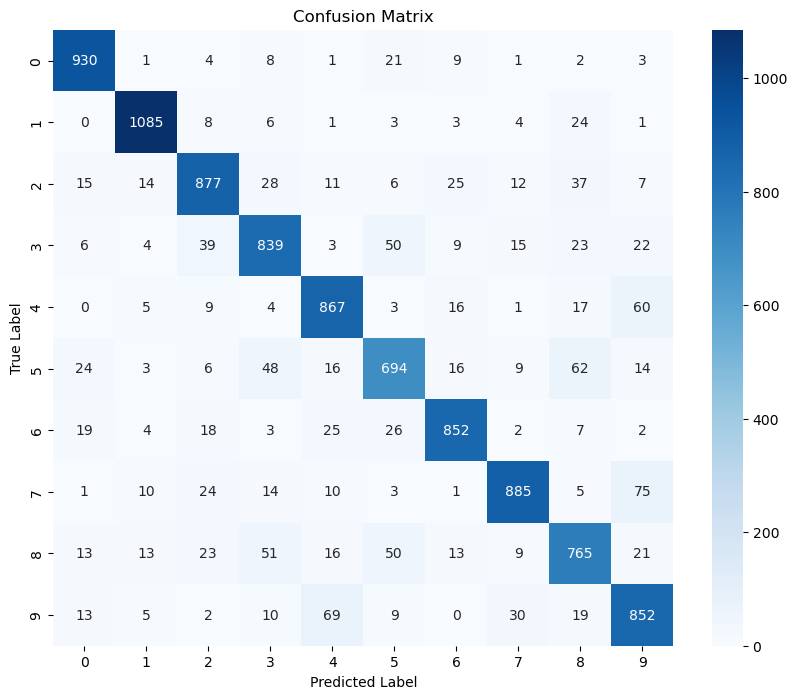


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       980
           1       0.95      0.96      0.95      1135
           2       0.87      0.85      0.86      1032
           3       0.83      0.83      0.83      1010
           4       0.85      0.88      0.87       982
           5       0.80      0.78      0.79       892
           6       0.90      0.89      0.90       958
           7       0.91      0.86      0.89      1028
           8       0.80      0.79      0.79       974
           9       0.81      0.84      0.82      1009

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [8]:
import seaborn as sns

def plot_confusion_matrix(true_labels, predictions):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(optimised_labels, optimised_preds)

# Print classification report
print("\nClassification Report:")
print(classification_report(optimised_labels, optimised_preds))

### Error Analysis

Let's look at some misclassified examples to understand where our model struggles:

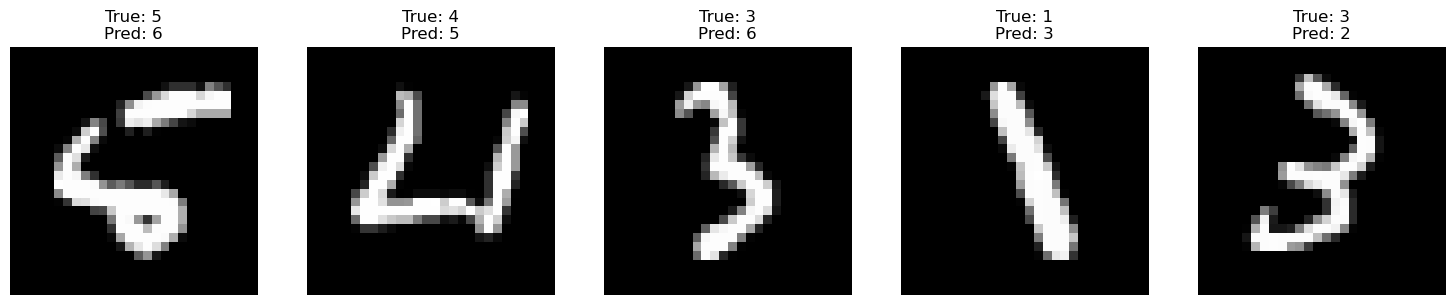

In [9]:
def show_misclassified_examples(model, data_loader, num_examples=5):
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Find misclassified examples
            mask = (predicted != labels)
            misclassified_images.extend(images[mask].cpu())
            misclassified_labels.extend(labels[mask].cpu())
            misclassified_preds.extend(predicted[mask].cpu())

            if len(misclassified_images) >= num_examples:
                break

    # Display examples
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 3))
    for i in range(num_examples):
        axes[i].imshow(misclassified_images[i].squeeze(), cmap='gray')
        axes[i].set_title(f'True: {misclassified_labels[i]}\nPred: {misclassified_preds[i]}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_misclassified_examples(optimised_model, test_loader)

### Model Comparison Summary

Let's compare the performance of our different models:

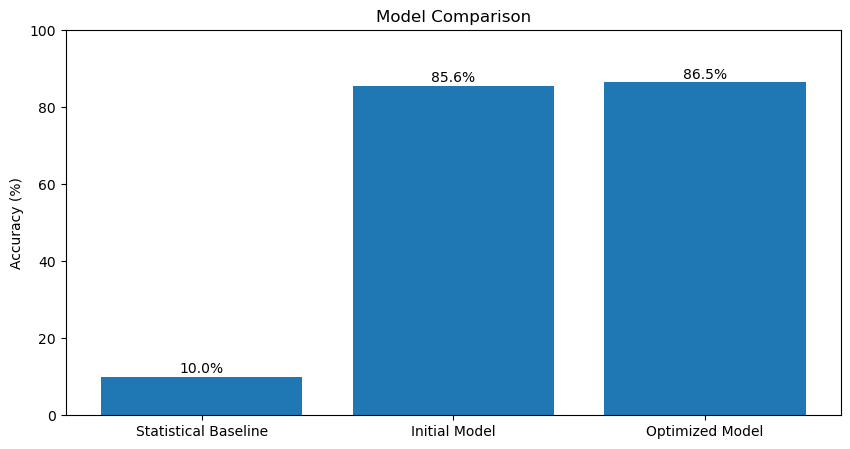

In [10]:
results_summary = {
    'Statistical Baseline': statistical_baseline * 100,
    'Initial Model': baseline_accuracy,
    'Optimized Model': optimised_accuracy
}

plt.figure(figsize=(10, 5))
plt.bar(results_summary.keys(), results_summary.values())
plt.title('Model Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
for i, v in enumerate(results_summary.values()):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center')
plt.show()

## Conclusions and Next Steps

Through this notebook, we've demonstrated the complete machine learning workflow:

1. **Problem Definition**: MNIST digit classification
2. **Data Assembly**: 60,000 training images, 10,000 test images
3. **Evaluation Protocol**: Accuracy and confusion matrix
4. **Data Preparation**: Normalization and tensor conversion
5. **Baseline Model**: Simple linear classifier
6. **Improved Model**: Convolutional Neural Network
7. **Hyperparameter Optimization**: Learning rate and batch size tuning

### Potential Improvements:
1. Data augmentation to improve robustness
2. Deeper network architecture
3. Ensemble methods
4. Additional regularization techniques
5. Learning rate scheduling

### Resources for Further Learning:
- PyTorch Documentation: https://pytorch.org/docs/
- Deep Learning Book: https://www.deeplearningbook.org/
- PyTorch Tutorials: https://pytorch.org/tutorials/

In [11]:
# Save the final model
torch.save(optimised_model.state_dict(), 'mnist_cnn_final.pth')
print("Final model saved to 'mnist_cnn_final.pth'")

Final model saved to 'mnist_cnn_final.pth'
